# Pre-allocated *d*-Simplex fixed classifier

In this code session, we will see how:
- define a *d*-Simplex fixed classifier with *K* pre-allocated classes
- pre-allocated *d*-Simplex fixed classifier provides stationary representation


Code inspired from https://github.com/NiccoBiondi/cores-compatibility

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'

## *d*-Simplex Fixed classifier with *K* pre-allocated classes

In [2]:
"""
    LeNet++ as described in the Center Loss paper.
"""
class LeNet(nn.Module):
    def __init__(self, num_classes=30, feat_dim=64, batch_norm=True, **kwargs):
        self.enable_batch_norm = batch_norm
        self.feat_dim = feat_dim

        activation_function = nn.ReLU

        super(LeNet, self).__init__()

        self.conv1_1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.batch_norm1_1 = nn.BatchNorm2d(32)
        self.act1_1 = activation_function()

        self.conv1_2 = nn.Conv2d(32, 32, 5, stride=1, padding=2)
        self.batch_norm1_2 = nn.BatchNorm2d(32)
        self.act1_2 = activation_function()

        self.conv2_1 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.batch_norm2_1 = nn.BatchNorm2d(64)
        self.act2_1 = activation_function()

        self.conv2_2 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.batch_norm2_2 = nn.BatchNorm2d(64)
        self.act2_2 = activation_function()

        self.conv3_1 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        self.batch_norm3_1 = nn.BatchNorm2d(128)
        self.act3_1 = activation_function()

        self.conv3_2 = nn.Conv2d(128, 128, 5, stride=1, padding=2)
        self.batch_norm3_2 = nn.BatchNorm2d(128)
        self.act3_2 = activation_function()

        self.fc = nn.Linear(128 * 3 * 3, feat_dim, bias=False)

        self.classifier = nn.Linear(feat_dim, num_classes, bias=False)

    @property
    def feature_input_size(self):
        return 128 * 3 * 3

    def forward(self, x, ind=None):
        if self.enable_batch_norm:
            out = self.act1_1(self.batch_norm1_1(self.conv1_1(x)))
            out = self.act1_2(self.batch_norm1_2(self.conv1_2(out)))
        else:
            out = self.act1_1(self.conv1_1(x))
            out = self.act1_2(self.conv1_2(out))
        out = F.max_pool2d(out, 2)

        if self.enable_batch_norm:
            out = self.act2_1(self.batch_norm2_1(self.conv2_1(out)))
            out = self.act2_2(self.batch_norm2_2(self.conv2_2(out)))
        else:
            out = self.act2_1(self.conv2_1(out))
            out = self.act2_2(self.conv2_2(out))
        out = F.max_pool2d(out, 2)
        if self.enable_batch_norm:
            out = self.act3_1(self.batch_norm3_1(self.conv3_1(out)))
            out = self.act3_2(self.batch_norm3_2(self.conv3_2(out)))
        else:
            out = self.act3_1(self.conv3_1(out))
            out = self.act3_2(self.conv3_2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 128 * 3 * 3)
        embeddings = self.fc(out)
        out = self.classifier(embeddings)

        return embeddings, out

In [3]:
def dsimplex(num_classes=10, device='cuda'):
    def simplex_coordinates(n, device):
        t = torch.zeros((n + 1, n), device=device)
        torch.eye(n, out=t[:-1,:], device=device)
        val = (1.0 - torch.sqrt(1.0 + torch.tensor([n], device=device))) / n
        t[-1,:].add_(val)
        t.add_(-torch.mean(t, dim=0))
        t.div_(torch.norm(t, p=2, dim=1, keepdim=True)+ 1e-8)
        return t.cpu()

    feat_dim = num_classes - 1
    ds = simplex_coordinates(feat_dim, device)
    return ds

def dSimplexLeNetPP(starting_classes=10, feat_size=9, device='cuda'):
    model = LeNet(starting_classes, feat_size)
    fixed_weights = dsimplex(num_classes=(feat_size + 1), device=device)
    model.classifier.weight.requires_grad = False  # set no gradient for the fixed classifier
    model.classifier.weight.copy_(fixed_weights)   # set the weights for the classifier

    model.to(device)
    return model

In [ ]:
# instantiate a pre-allocated d-simplex with K=10 classes
model = dSimplexLeNetPP(starting_classes=3, feat_size=2, device=device)
print(model)

## Stationary Representations

2D Toy Example.
From 2 to 3 MNIST classes with trainable and fixed classifier.

TBN: In order to plot a regular simplex where the dimension of the space is d = K - 1, the maximum value we can set K is 3.

### Training Loop

In [5]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

# Function to filter a dataset by a specific set of classes
def filter_dataset_by_classes(dataset, classes):
    indices = [i for i, (x, y) in enumerate(dataset) if y in classes]
    return Subset(dataset, indices)

# Split MNIST into two datasets: one with 2 classes and one with 3 classes
classes_set_1 = [0, 1]     # First dataset with 2 classes
classes_set_2 = [0, 1, 2]  # Second dataset with 3 classes (note: 2 old and 1 new)

# Filter datasets
train_set_1 = filter_dataset_by_classes(mnist_train, classes_set_1)
train_set_2 = filter_dataset_by_classes(mnist_train, classes_set_2)

# Create data loaders
batch_size = 64
train_loader_1 = DataLoader(train_set_1, batch_size=batch_size, shuffle=True)
train_loader_2 = DataLoader(train_set_2, batch_size=batch_size, shuffle=True)

# Define a generic training function
def train_model(model, train_loader, optimizer, criterion, epochs=5, device='cuda'):
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            embeddings, outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}", end="\r")

#### Fixed classifier with 2 classes

In [26]:
# instantiate a pre-allocated d-simplex with K=10 classes
model = dSimplexLeNetPP(starting_classes=3, feat_size=2, device=device)

# Optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train on the first dataset (2 classes)
print("Training on first dataset (2 classes)")
train_model(model, train_loader_1, optimizer, criterion, epochs=5, device=device)
torch.save(model.state_dict(), '../output/fixed_classifier_2_classes.pth') # save model to plot the features

Training on first dataset (2 classes)
Epoch 1, Loss: 0.042149836367131294
Epoch 2, Loss: 0.003061708066463949
Epoch 3, Loss: 0.001339020125591971
Epoch 4, Loss: 0.0002384578287629152
Epoch 5, Loss: 8.739930332542125e-05


#### Fixed classifier with 3 classes

In [27]:
# instantiate a pre-allocated d-simplex with K=10 classes
model = dSimplexLeNetPP(starting_classes=3, feat_size=2, device=device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train on the second dataset (3 classes)
print("Training on second dataset (3 classes)")
train_model(model, train_loader_2, optimizer, criterion, epochs=5, device=device)
torch.save(model.state_dict(), '../output/fixed_classifier_3_classes.pth') # save model to plot the features

Training on second dataset (3 classes)
Epoch 1, Loss: 0.1179382833938986
Epoch 2, Loss: 0.008370841998780368
Epoch 3, Loss: 0.00441601684780235
Epoch 4, Loss: 0.002181733953488113
Epoch 5, Loss: 0.0015518604413652698


#### Trainable classifier with 2 classes

In [22]:
# trainable lenetpp with 2 classes
model = LeNet(2, 2)
model = model.to('cuda')

# Optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train on the first dataset (2 classes)
print("Training on first dataset (2 classes)")
train_model(model, train_loader_1, optimizer, criterion, epochs=5, device=device)
torch.save(model.state_dict(), '../output/model_2_classes.pth') # save model to plot the features

Training on first dataset (2 classes)
Epoch 1, Loss: 0.010004516083178962
Epoch 2, Loss: 0.0012959379682131544
Epoch 3, Loss: 0.0002983972233518804
Epoch 4, Loss: 0.00012330180657722803
Epoch 5, Loss: 2.70380874477875e-05


#### Trainable classifier with 3 classes

In [23]:
# trainable lenetpp with 3 classes
model = LeNet(3,2)
model = model.to('cuda')

# Optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train on the second dataset (3 classes)
print("Training on second dataset (3 classes)")
train_model(model, train_loader_2, optimizer, criterion, epochs=5, device=device)
torch.save(model.state_dict(), '../output/model_3_classes.pth') # save model to plot the features

Training on second dataset (3 classes)
Epoch 1, Loss: 0.03029584723484844
Epoch 2, Loss: 0.00550514256375737
Epoch 3, Loss: 0.002914399960472301
Epoch 4, Loss: 0.0016698924539390726
Epoch 5, Loss: 0.0011077428132114985


### Plot function

In [17]:
import matplotlib.pyplot as plt

def plot_embedding(model, train_loader, ax, title, color_map, device=device):
    model.eval()  # Set the model to evaluation mode
    
    # Get the features and labels from the train set
    features = []
    labels = []
    
    with torch.no_grad():
        for images, target in train_loader:
            images, taget = images.to(device), target.to(device)
            # Get the embeddings before the final layer
            embeddings, _ = model(images)  # Remove the last layer (logits)
            features.append(embeddings)
            labels.append(target)
    
    # Convert lists to tensors
    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    
    # Get the classifier's weight matrix (for the line starting from (0,0))
    classifier_weights = model.classifier.weight.detach().cpu().numpy()

    # Plot the 2D embeddings
    scatter = ax.scatter(features[:, 0], features[:, 1], c=[color_map[l] for l in labels], cmap='tab10', alpha=0.7)
    ax.set_xlim([-40, 40])
    ax.set_ylim([-40, 40])
    ax.set_title(f'{title}')
    
    # Plot lines from (0, 0) for each classifier dimension (output class)
    for i in range(classifier_weights.shape[0]):
        ax.plot([0, classifier_weights[i, 0] * 100], 
                [0, classifier_weights[i, 1] * 100], 
                color=color_map[i],  # Color the line same as the class color
                label=f'Class {i}')  # Scaled for better visualization

    ax.legend()
    ax.grid(True)

# Consistent color mapping for 4 classes
color_map = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:red'}

/tmp/ipykernel_294583/401759644.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(features[:, 0], features[:, 1], c=[color_map[l] for l in labels], cmap='tab10', alpha=0.7)


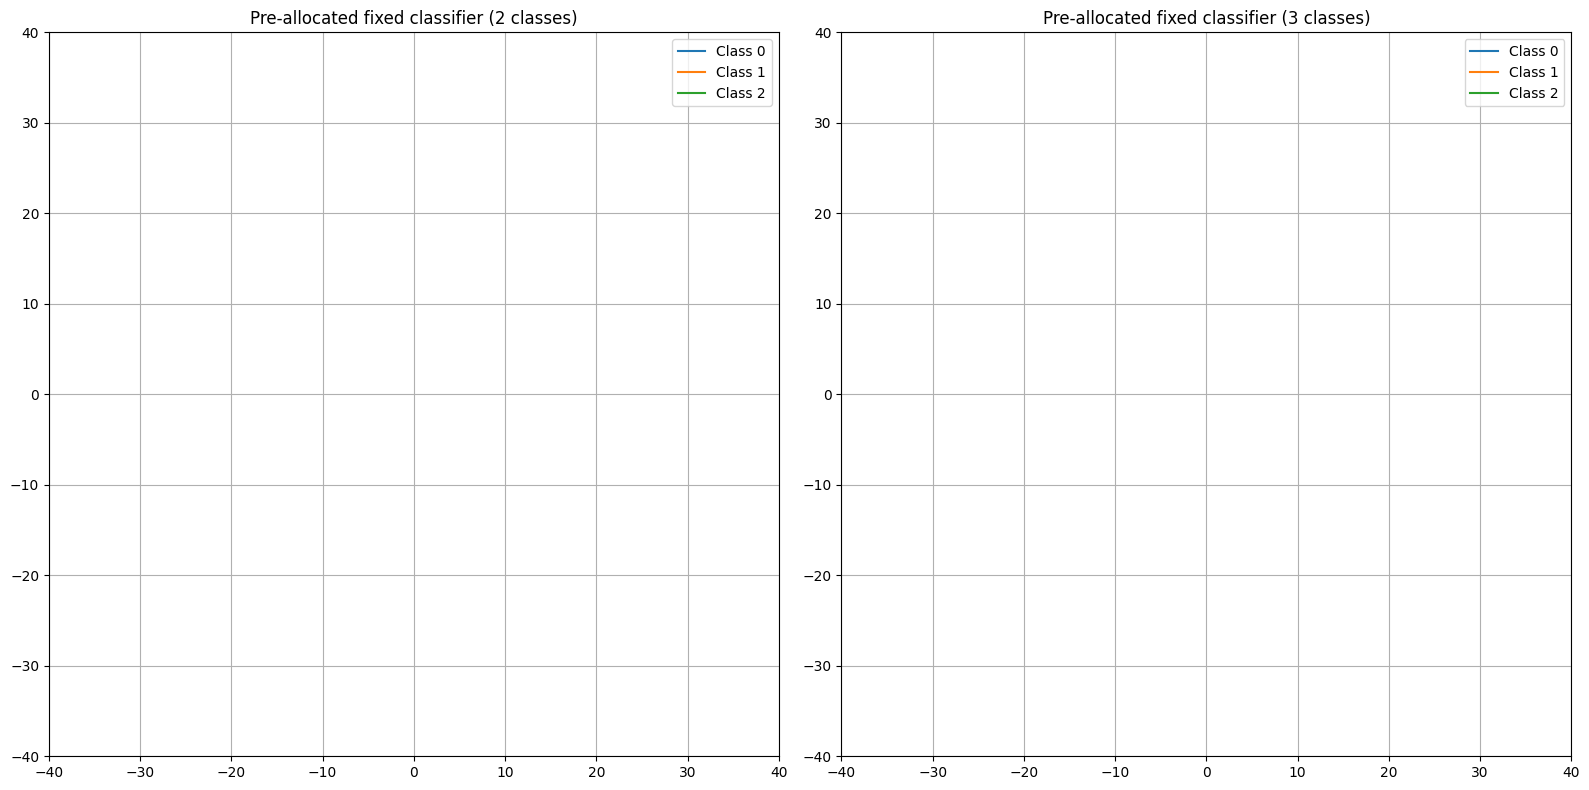

In [24]:
# Create subplots for both models
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the embedding for the first model (2 classes)
model = dSimplexLeNetPP(3, 2)
model.load_state_dict(torch.load('../output/fixed_classifier_2_classes.pth'))
plot_embedding(model, train_loader_1, axs[0], title="Pre-allocated fixed classifier (2 classes)", color_map=color_map, device=device)

# Load the model trained on the second dataset and plot its embeddings
model.load_state_dict(torch.load('../output/fixed_classifier_3_classes.pth'))
plot_embedding(model, train_loader_2, axs[1], title="Pre-allocated fixed classifier (3 classes)", color_map=color_map, device=device)

plt.tight_layout()
plt.show()

/tmp/ipykernel_294583/401759644.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(features[:, 0], features[:, 1], c=[color_map[l] for l in labels], cmap='tab10', alpha=0.7)


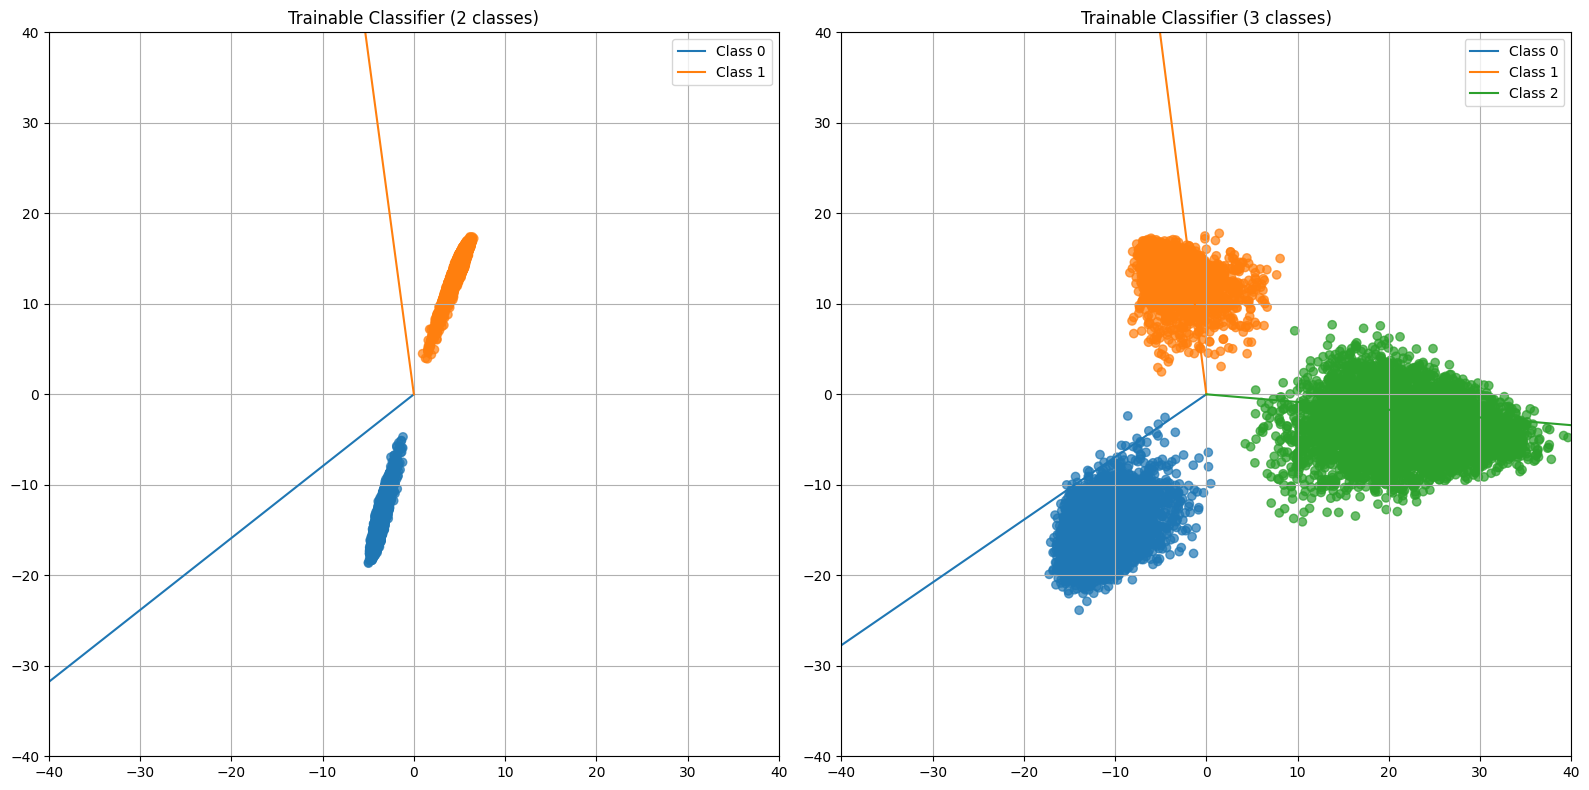

In [25]:
# Create subplots for both models
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

model = LeNet(2,2)
model = model.to('cuda')
model.load_state_dict(torch.load('../output/model_2_classes.pth'))
plot_embedding(model, train_loader_1, axs[0], title="Trainable Classifier (2 classes)", color_map=color_map, device=device)

# Load the model trained on the second dataset and plot its embeddings
model = LeNet(3, 2)
model = model.to('cuda')
model.load_state_dict(torch.load('../output/model_3_classes.pth'))
plot_embedding(model, train_loader_2, axs[1], title="Trainable Classifier (3 classes)", color_map=color_map, device=device)

plt.tight_layout()
plt.show()